In [6]:
import pickle
import numpy as np
import pandas as pd
import lightgbm
import toad
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.metrics import AUC

from deepctr.models.gbdt2nn.gbdt_predict_leaf import gbdt_predict
from deepctr.models.gbdt2nn.leaf2emb import EmbeddingLeafModel
from deepctr.feature_column import DenseFeat, get_feature_names, SparseFeat
from deepctr.callbacks import ModifiedExponentialDecay
from deepctr.layers import custom_objects
from deepctr.metrics import calc_lift3, cal_ks
from basenet import GBDT_Resnet


def load_data(data_dir):
    trn_x = np.load(data_dir+"/train_features.npy").astype(np.float32)
    trn_y = np.load(data_dir+"/train_labels.npy").astype(np.float32)
    vld_x = np.load(data_dir+"/test_features.npy").astype(np.float32)
    vld_y = np.load(data_dir+"/test_labels.npy").astype(np.float32)

    vld_x1 = np.load(data_dir+"/test_3oot_features.npy").astype(np.float32)
    vld_y1 = np.load(data_dir+"/test_3oot_labels.npy").astype(np.float32)
    vld_x2 = np.load(data_dir+"/test_4oot_features.npy").astype(np.float32)
    vld_y2 = np.load(data_dir+"/test_4oot_labels.npy").astype(np.float32)
    vld_x3 = np.load(data_dir+"/test_5oot_features.npy").astype(np.float32)
    vld_y3 = np.load(data_dir+"/test_5oot_labels.npy").astype(np.float32)

    mean = np.mean(trn_x, axis=0)
    std = np.std(trn_x, axis=0)
    trn_x = (trn_x - mean) / (std + 1e-5)
    vld_x = (vld_x - mean) / (std + 1e-5)

    vld_x1 = (vld_x1 - mean) / (std + 1e-5)
    vld_x2 = (vld_x2 - mean) / (std + 1e-5)
    vld_x3 = (vld_x3 - mean) / (std + 1e-5)

    return trn_x, trn_y, vld_x, vld_y, vld_x1, vld_y1, vld_x2, vld_y2, vld_x3, vld_y3


def load_lightgbm(path):
    gbm = lightgbm.Booster(model_file=path)
    return gbm


def load_lightgbm_pkl(path):
    pkl_file = open(path, 'rb')
    gbm = pickle.load(pkl_file)
    pkl_file.close()
    return gbm

At first, use run_encoding_cate.py and run_encoding_nume.py to do some feature engineering.
The lightgbm_8tree.pkl is the first 8-tree model extracted from another complete boosting tree.
Deciding the number of trees is tricky in that either too small or too large is not good.
For this demo, maxleaf=2 is set in training lightgbm. Because we only have 8 trees here, all 8 trees
are grouped to 1 to prevent dimension curse, and we will define feat_per_group features to be used for a group.

In [20]:
# configuration
# nslices means the number of groups
args = {'nslices': 1, 'maxleaf': 2, 'embsize': 32, 'feat_per_group': 50, 'group_method': 'Equal'}

# load numerical features and get gbdt leaf predictions
train_x, train_y, test_x, test_y, \
oot1_x, oot1_y, oot2_x, oot2_y, oot3_x, oot3_y = load_data('../data/gbdt2nn/risk_offline_nume')
gbm = load_lightgbm('../data/gbdt2nn/lightgbm_8tree.pkl')
leaf_preds, tree_outputs, \
group_average, used_features, n_models, max_ntree_per_split, min_len_features = \
    gbdt_predict(train_x, gbm, args)
test_leaf_preds, test_tree_outputs, _, _, _, _, _ = gbdt_predict(test_x, gbm, args)
model_input = {'gbm_leaf_predictions': leaf_preds}
test_model_input = {'gbm_leaf_predictions': test_leaf_preds}
tree_outputs = np.asarray(tree_outputs).reshape((n_models, leaf_preds.shape[0])).transpose((1, 0))
test_tree_outputs = np.asarray(test_tree_outputs).reshape((n_models, test_leaf_preds.shape[0])).transpose((1, 0))

Model Interpreting...
[(8,)]
Model Interpreting...
[(8,)]


In [3]:
# embed leaves
emb_model = EmbeddingLeafModel([DenseFeat('gbm_leaf_predictions', leaf_preds.shape[1])],
                               n_models,
                               args['maxleaf'],
                               args['embsize'],
                               'binary',
                               group_average)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
emb_model.compile(loss=['mse', None], optimizer=opt, metrics=[['mse'], ['AUC']])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_final_score_auc',
                                             patience=10,
                                             mode='max',
                                             restore_best_weights=True)
history = emb_model.fit(model_input, [tree_outputs, train_y],
                          batch_size=64,
                          validation_data=(test_model_input, [test_tree_outputs, test_y]),
                          epochs=100,
                          callbacks=[callback])
model_new = tf.keras.Model(inputs=emb_model.input, outputs=emb_model.get_layer('leaf2emb').output)

Epoch 1/100
126/126 [==============================] - 1s 11ms/step - loss: 9.9767 - emb2score_loss: 9.9767 - emb2score_mse: 9.9767 - final_score_auc: 0.6184 - val_loss: 7.5747 - val_emb2score_loss: 7.5747 - val_emb2score_mse: 7.5747 - val_final_score_auc: 0.6186

After dense features are transformed to leaf embeddings, concat them with sparse embeddings,
and build a resnet block. Resnet block is proved to be efficient for tabular structured data.
Please refer to basenet.py for more coding details.

In [21]:
# define sparse features and dense features(leaf embedding)
train_cate = pd.read_csv('../data/gbdt2nn/risk_offline_cate/train_cate.csv')
test_cate = pd.read_csv('../data/gbdt2nn/risk_offline_cate/test_cate.csv')
sparse_features = ['ali_rain_score', 'bj_jc_m36_consume_cnt', 'td_zhixin_score', 'hds_36m_purchase_steady',
            'hds_36m_total_purchase_cnt', 'hds_36m_month_max_purchase_money_excp_doub11_12',
            'hds_36m_doub11_12_total_purchase_money', 'ab_local_ratio', 'ab_mobile_cnt', 'cust_id_area',
            'cust_work_city', 'immediate_relation_cnt', 'relation_contact_cnt', 'study_app_cnt',
            'ab_local_cnt', 'ab_prov_cnt', 'credit_repayment_score_bj_2', 'td_xyf_dq_score',
                   'hds_phone_rich_rank', 'hds_mobile_rich', 'hds_recent_consumme_active_rank', 'idcard_district_grade',
            'idcard_rural_flag', 'selffill_degree', 'selffill_is_have_creditcard', 'selffill_marital_status',
            'hds_mobile_reli_rank_Ma', 'hds_mobile_reli_rank_Mb', 'hds_mobile_reli_rank_M0', 'is_ios', 'is_male']
train_cate[sparse_features] = train_cate[sparse_features].replace([-1], 0)
test_cate[sparse_features] = test_cate[sparse_features].replace([-1], 0)
cat_feature_columns = [SparseFeat(feat, vocabulary_size=train_cate[feat].max() + 1,
                                  embedding_dim=4) for i, feat in enumerate(sparse_features)]
num_feature_columns = [DenseFeat('gbm_leaf_predictions', leaf_preds.shape[1])]
dnn_feature_columns = cat_feature_columns + num_feature_columns
linear_feature_columns = cat_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
train_final_input = {name: train_cate[name] if name != 'gbm_leaf_predictions' else leaf_preds for name in feature_names}
test_final_input = {name: test_cate[test_cate['set'] == '2test'][name]
if name != 'gbm_leaf_predictions' else test_leaf_preds for name in feature_names}

In [5]:
model2 = GBDT_Resnet(linear_feature_columns, dnn_feature_columns, model_new,
                     num_outdim=1, dnn_hidden_units=(32, 16, 8), dnn_use_bn=True,
                     l2_reg_dnn=0, dnn_dropout=0.1, dnn_activation='relu', seed=1024)
optimizer = keras.optimizers.Adam(learning_rate=ModifiedExponentialDecay(0.0001, max_iter_num=50*126))
model2.compile(optimizer=optimizer,
               loss=keras.losses.binary_crossentropy,
               metrics=AUC(name='task1_AUC'))
history = model2.fit(train_final_input,
                     train_y,
                     batch_size=64,
                     epochs=100,
                     validation_data=(test_final_input, test_y),
                     callbacks=[
                            tf.keras.callbacks.EarlyStopping(monitor='val_task1_AUC',
                                                             patience=10,
                                                             mode='max',
                                                             restore_best_weights=True)
                        ]
                     )

Epoch 1/100
126/126 [==============================] - 6s 47ms/step - loss: 0.5954 - task1_AUC: 0.5379 - val_loss: 0.3068 - val_task1_AUC: 0.4894
Epoch 2/100
126/126 [==============================] - 5s 39ms/step - loss: 0.3022 - task1_AUC: 0.5289 - val_loss: 0.2124 - val_task1_AUC: 0.5579

D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


-----
Model Interpreting...
[(8,)]
-----
Model Interpreting...
[(8,)]
-----
Model Interpreting...
[(8,)]
-----
Model Interpreting...
[(8,)]
-----
Model Interpreting...
[(8,)]


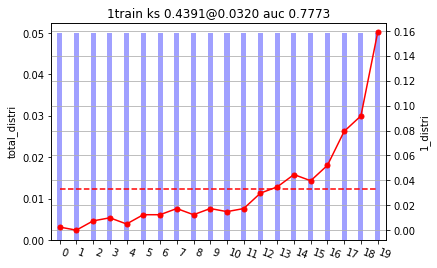

D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\ProgramData\Anaconda3\envs\python3.6_tf2\lib\site-packages\ipykernel\__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

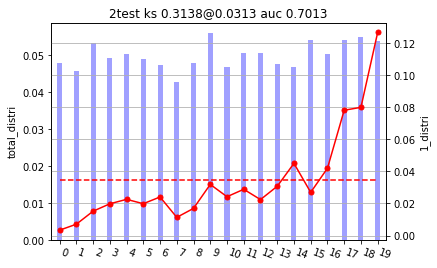

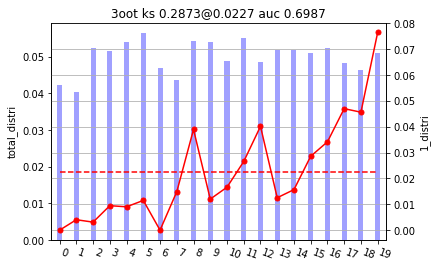

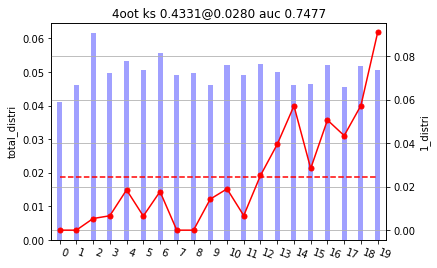

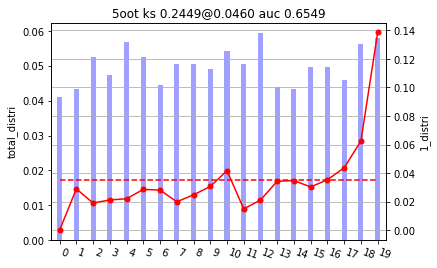

In [14]:
# prediction
pred_y = model2.predict(train_final_input)
train_cate['pred'] = pred_y
selected_psi = ['pred']
target = 'fpd4'
combiner = toad.transform.Combiner()
combiner.fit(train_cate[train_cate['set'] == '1train'][selected_psi + [target]],
             y=target,
             n_bins=20,
             method='quantile',
             empty_separate=True)
dataset = ((train_x, train_y), (test_x, test_y),
           (oot1_x, oot1_y), (oot2_x, oot2_y), (oot3_x, oot3_y))
for index, i in enumerate(['1train', '2test', '3oot', '4oot', '5oot']):
    print('-----')
    test_leaf_preds, test_tree_outputs, \
    group_average, used_features, n_models, max_ntree_per_split, min_len_features = \
        gbdt_predict(dataset[index][0], gbm, args)
    if i == '1train':
        test_cate_input = {name: train_cate[train_cate['set'] == i][name]
                           if name != 'gbm_leaf_predictions' else test_leaf_preds
                           for name in feature_names}
        df = train_cate[train_cate['set'] == i]
    else:
        test_cate_input = {name: test_cate[test_cate['set'] == i][name]
                           if name != 'gbm_leaf_predictions' else test_leaf_preds
                           for name in feature_names}
        df = test_cate[test_cate['set'] == i]
    df['pred'] = model2.predict(test_cate_input)
    ks = cal_ks(df['pred'].values, df['fpd4'].values)
    auc = roc_auc_score(df['fpd4'].values, df['pred'].values)
    plt.close('all')
    df['range'] = combiner.transform(df['pred'])
    _, ax = calc_lift3(df, 'range', 'fpd4', range_col='range',
                           title_name=i +' ks {:.4f}@{:.4f} auc {:.4f}'.format(ks[0], ks[1], auc))
    plt.show()